In [ ]:
# Filtering
# Imputation
# Feature Selection -- Correlation
# Spatial Autocorrelation

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Dataset
wells=pd.read_csv('../data/filtered_2.csv')
wells.shape

(16685, 103)

In [4]:
# Filter columns to select predictor and target variables
predictors = ['ENVProdWellType','ENVInterval','ENVSpacingAssumption','Latitude','Longitude','TVD_FT','Vintage','LateralLength_FT','ProppantIntensity_LBSPerFT','FluidIntensity_BBLPerFT',
              'ParentChildSameZone','WellDensitySameZone','WellsPerSectionSameZone','GasShrink_PCT','NGLYield_BBLPerMMCF','GenericDrainage_AC','Payzone_FT','GammaRay_API',
              'BulkDensity_GPerCC','Resistivity_OHMSM', 'DensityPorosity_PCT','EffectivePorosity_PCT', 'ClayVolume_PCT', 'NonClayVolume_PCT', 'WaterSaturation_PCT', 'PhiH_FT',
              'HCPV_PCT', 'HeightOfHCPV_FT', 'TotalOrganicCarbon_WTPCT'
              ]
target = ['EURWH_MBOE','OilEURWH_MBBL','GasEURWH_BCF']

wells['ENVProdWellType']= wells['ENVProdWellType'].replace({'LIQUIDS RICH GAS (10-40% WH LIQUIDS)': 'CONDENSATE',
                                                           'OIL (40%+ WH LIQUIDS)': 'OIL',
                                                           'DRY GAS (0-1% WH LIQUIDS)':'DRY GAS',
                                                           'WET GAS (1-10% WH LIQUIDS)':'WET GAS'})

wells_filtered = wells[predictors + target]
wells_filtered.shape

(16685, 32)

In [5]:
# Filter rows to include recent wells
wells_filtered = wells_filtered[wells_filtered["Vintage"] >= 2010]

print("Number of observations with null values:", wells_filtered.isnull().any(axis = 1).sum())
print("Null values per column:\n", wells_filtered.isnull().sum(axis = 0))

Number of observations with null values: 5854
Null values per column:
 ENVProdWellType                  0
ENVInterval                    112
ENVSpacingAssumption          3908
Latitude                         0
Longitude                        0
TVD_FT                          80
Vintage                          0
LateralLength_FT                14
ProppantIntensity_LBSPerFT    1544
FluidIntensity_BBLPerFT       1463
ParentChildSameZone            130
WellDensitySameZone           3908
WellsPerSectionSameZone        130
GasShrink_PCT                 1016
NGLYield_BBLPerMMCF           1016
GenericDrainage_AC            1018
Payzone_FT                     110
GammaRay_API                   110
BulkDensity_GPerCC             110
Resistivity_OHMSM              110
DensityPorosity_PCT            110
EffectivePorosity_PCT          110
ClayVolume_PCT                 110
NonClayVolume_PCT              110
WaterSaturation_PCT            110
PhiH_FT                        110
HCPV_PCT           

In [6]:
# One-hot encoding categorical variables
categorical = ['ENVProdWellType','ENVInterval','ParentChildSameZone']

for feat in categorical:
  one_hot = pd.get_dummies(wells_filtered[feat])
  wells_filtered = wells_filtered.drop(feat, axis = 1)
  wells_filtered = wells_filtered.join(one_hot)

print(wells_filtered.shape)

(16505, 51)


In [7]:
# Data imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer()
imputed_values = imputer.fit_transform(wells_filtered)

In [8]:
wells_filtered.loc[:] = imputed_values
print("Number of observations with null values:", wells_filtered.isnull().any(axis = 1).sum())

Number of observations with null values: 0


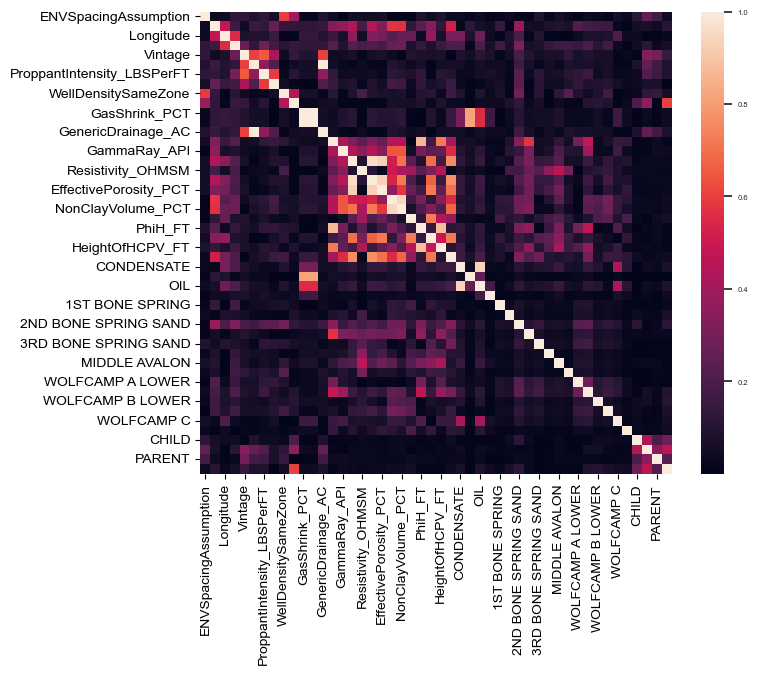

In [9]:
# Assess feature correlation
X = wells_filtered[[column for column in wells_filtered.columns if column not in target]]
y = wells_filtered[[column for column in wells_filtered.columns if column in target]]

correlation = X.corr().abs()

f, ax = plt.subplots(1, figsize=(7.6, 6))
sns.set(font_scale=0.5)
sns.heatmap(correlation)
f.savefig("../figures/correlation.png")

In [10]:
correlated = []
correlation_mat = np.triu(correlation, 1)

for row in correlation.index:
    for col in correlation.columns:
        if correlation_mat[correlation.index.get_loc(row), correlation.index.get_loc(col)] > 0.9:
            correlated.append((row, col))

print("Highly correlated features:")
correlated

Highly correlated features:


[('LateralLength_FT', 'GenericDrainage_AC'),
 ('GasShrink_PCT', 'NGLYield_BBLPerMMCF'),
 ('BulkDensity_GPerCC', 'DensityPorosity_PCT'),
 ('BulkDensity_GPerCC', 'EffectivePorosity_PCT'),
 ('DensityPorosity_PCT', 'EffectivePorosity_PCT'),
 ('ClayVolume_PCT', 'NonClayVolume_PCT'),
 ('CONDENSATE', 'OIL')]

In [11]:
# Assessing spatial autocorrelation
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights

xy = wells_filtered[["Latitude", "Longitude"]]
gdf = gpd.GeoDataFrame(
    xy,
    geometry=gpd.points_from_xy(xy['Longitude'], xy['Latitude']),
    crs='EPSG:4326'
)

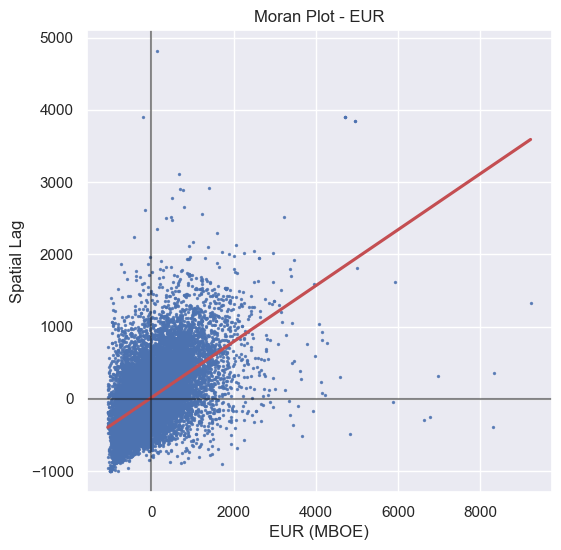

In [17]:
w = weights.KNN.from_dataframe(gdf, k=5)
w.transform = "R"

pred_lag_std = weights.spatial_lag.lag_spatial(w, y["EURWH_MBOE"] - y["EURWH_MBOE"].mean())

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x = y["EURWH_MBOE"] - y["EURWH_MBOE"].mean(),
    y = pred_lag_std,
    ci=None,
    line_kws={"color": "r"},
    scatter_kws={'s':2}
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - EUR")
ax.set_xlabel("EUR (MBOE)")
ax.set_ylabel("Spatial Lag")
sns.set(font_scale=0.5)

plt.show()

In [18]:
moran = esda.moran.Moran(y["EURWH_MBOE"], w)
print(moran.I)
print(moran.p_sim)

0.38733627953773225
0.001


In [ ]:
wells_filtered.to_csv("../data/imputed.csv")